<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork820-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Tackle Imbalanced Data Challenge**


Estimated time needed: **60** minutes


In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions: 


| Task Name     | Class Ratio (Negative vs. Positive)  |
| ------------- |:-------------:|
| _Credit Card Fraud Detection_      | ~1000 : 1      | 
| _Predicting Customer Churn_ | ~5 : 1      | 
| _Tumor Type Estimation_ | ~2 : 1     | 
| _Predicting Job Change_ | ~10 : 1      | 


Next, you will try to tackle the imbalanced data challenges in the above tasks using class weighting and resampling methods:
- Effective class weighting strategies will assign minority class with more weights, so that it may have a larger impact on the model training process
- Resampling methods will generate synthetic datasets from the original datasets


## Objectives


After completing this lab you will be able to:


* Identify typical patterns of imbalanced data challenges
* Apply `Class Re-weighting` method to adjust the impacts of different classes in model training processes
* Apply `Oversampling` and `Undersampling` to generate synthetic datasets and rebalance classes
* Evaluate your consolidated classifiers using robust metrics such as `F-score` and `AUC`


In [4]:
import pandas as pd
import numpy as np
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from collections import Counter

Grid Search CV Methods.

In [5]:
RANDOM_STATE = 123

In [6]:
def grid_search_lr(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'class_weight': [
            {0: 0.05, 1: 0.95},
            {0: 0.1, 1: 0.9},
            {0: 0.2, 1: 0.8}
        ]
    }
    lr_model = LogisticRegression(random_state=random_state, max_iter=1000)
    grid_search = GridSearchCV(
        estimator=lr_model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        verbose=True
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

def grid_search_rf(X_train, y_train, random_state=RANDOM_STATE):
    param_grid = {
        'max_depth': [5, 10, 15, 20],
        'n_estimators': [25, 50, 100],
        'min_samples_split': [2, 5],
        'class_weight': [
            {0: 0.1, 1: 0.9},
            {0: 0.2, 1: 0.8},
            {0: 0.3, 1: 0.7}
        ]
    }
    rf_model = RandomForestClassifier(random_state=random_state)
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        verbose=True
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

In [7]:
def split_data(df, y_column, random_state=RANDOM_STATE):
    X = df.drop(y_column, axis=1)
    y = df[y_column]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

## Scenario: Credit Card Fraud Detection

Let's start with a credit card fraud detection scenario.
The dataset contains transactions made by credit cards. As you can imagine, the majority of transactions are normal and only a very few real fraud transactions are in the dataset. Our goal is to train a classification model to recognize those fraudulent credit card transactions.


In [8]:
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

In [9]:
credit_df.head()

,V14,V17,V4,V10,V28,Class
0,0.423619,-0.210863,0.933459,0.027866,0.019308,0
1,0.986727,0.174009,-2.019905,-1.620065,-0.307753,0
2,-0.023094,-0.541985,-0.902618,-0.192212,-0.048965,0
3,-0.152111,-0.615094,1.276126,-0.026822,0.044480,0
4,-0.535807,-0.248563,4.517539,1.871441,0.120955,0


In [10]:
Y_COLUMN = 'Class'

In [11]:
credit_df[Y_COLUMN].value_counts(normalize=True)

Class
0    0.999001
1    0.000999
Name: proportion, dtype: float64

<Axes: xlabel='Class'>

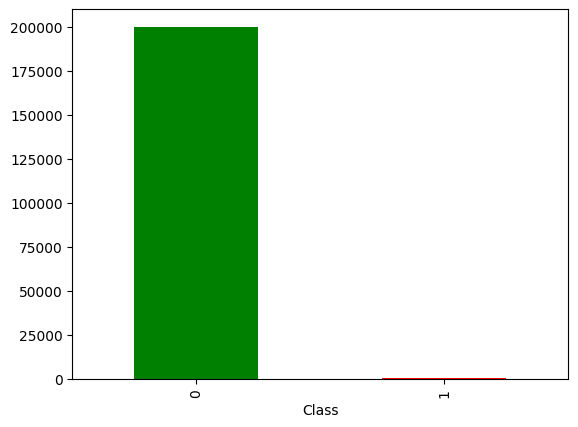

In [12]:
credit_df[Y_COLUMN].value_counts().plot.bar(color=['green', 'red'])

As you can see, we only have about 0.001% fraud transactions in the dataset and you can not even see it on the previous bar chart! This is an extremely imbalanced dataset.

In [13]:
X_train, X_test, y_train, y_test = split_data(credit_df, Y_COLUMN)

In [14]:
model = LogisticRegression(random_state=RANDOM_STATE,
                           max_iter=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [15]:
accuracy_score(y_test, preds)

0.9992757242757243

OK, it achieves 99% prediction accuracy on the test dataset, looks like a great model! Before concluding we have found a simple and great model to detect credit card frauds, let's try other metrics first.


### More Robust Evaluation Metrics


Here are some effective robust binary classification evaluation metrics such as Precision, Recall, and Fscore, which can be defined as follows:


- `Precision`: the percentage of accurately predicted positive instances

- `Recall`: the percentage of successfully recognized positive instances

- `Fscore`: can also be called F-beta score, which is a weighted average of precision and recall to evaluate the model. The weights between recall and precision are controlled by the `beta`  parameter, the default value is 1 so the most common F-beta is F1 score


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/images/evaluation_metrics.png" width="720" alt="evaluation metrics">
</center>


In addition, the plot of True positive rate and false positive ratio under different thresholds, known as Receiver operating characteristic `ROC` and its associated Area Under the Curve `AUC` are also reliable metrics.


In [52]:
def print_classification_metrics(y_true, y_pred, target='Original'):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fbeta, support = precision_recall_fscore_support(y_true, y_pred, beta=5, pos_label=1, average='binary')
    auc = roc_auc_score(y_test, preds)
    print(f"Accuracy is: {accuracy:.2f}")
    print(f"Precision is: {precision:.2f}")
    print(f"Recall is: {recall:.2f}")
    print(f"Fscore is: {fbeta:.2f}")
    print(f"AUC is: {auc:.2f}")
    return {
        'target': target,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f-score': fbeta,
        'auc': auc
    }

In [53]:
original = print_classification_metrics(y_test, preds)

Accuracy is: 0.86
Precision is: 0.68
Recall is: 0.28
Fscore is: 0.29
AUC is: 0.63


For many machine learning tasks on imbalanced datasets, like this credit card fraud detection, we normally care more about recall than precision. As a baseline, we want the model to be able to find all frauds and we would allow the model to make false-positive errors because the cost of false positives is usually not very high (maybe just costs a false notification email or phone call to confirm with customers). On the other hand, failing to recognize positive examples (such as fraud or a deadly disease) can be life-threatening 

As such, our priority is to improve the model's recall, then we will also want to keep precision as high as possible. 


### Synthetic Minority Oversampling Technique (SMOTE)


SMOTE first creates many pairs or small clusters with two or more similar instances, the measure by instance distance such as Euclidean distance.
Then, within the boundary of each pair or cluster, SMOTE uniformly permutes features value, one feature at a time, to populate a collection of similar synthesized instances within each pair or cluster.

As a result, SMOTE creates a class-balanced synthetic dataset without adding duplicated instances with minority labels. 


The `imblearn` package provides us with many effective samplers including `SMOTE`, `RandomOverSampler`, and `RandomUnderSampler`. Let's use its `SMOTE` class to define a SMOTE sampler first


In [18]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [19]:
smote_sampler = SMOTE(random_state=RANDOM_STATE)

In [20]:
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

<Axes: xlabel='Class'>

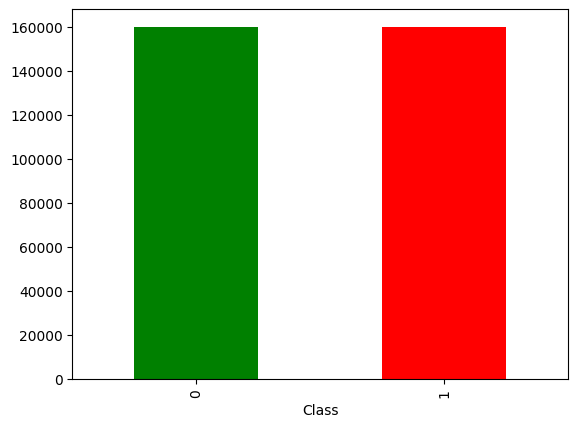

In [21]:
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [22]:
model.fit(X_smo, y_smo)
preds = model.predict(X_test)

In [54]:
smo = print_classification_metrics(y_test, preds, 'SMOTE')

Accuracy is: 0.86
Precision is: 0.68
Recall is: 0.28
Fscore is: 0.29
AUC is: 0.63


First, we can see AUC is improved from 0.72 to 0.91, this is a good sign as SMOTE improves model classification ability.


Next, let's take a look at the recall. The recall is now 0.88, mostly two times larger than the original recall value of 0.45. 


However, our model's precision is only 0.03. One possible reason is our dataset was extremely skewed, and oversampling the minority class significantly disrupts the original data distribution so that the model trained on the SMOTE dataset generates large false positives on the test dataset sampled from the original dataset.


As such, for an extremely skewed dataset, we generally do not use oversampling as it significantly shifts the original data distribution. 


Next, let's try class re-weighting to see if it can achieve better results than SMOTE in terms of Precision, Recall, and Fscore.


### Class reweighting


For binary classification models, its loss function is normally calculated via a sum of the loss with respect to class 0 and the loss with respect to class 1. By default, their class weights are all 1s meaning we treat each class equally important.

However, since the class distribution is skewed in imbalanced datasets and the loss function optimization process will be dominated by the majority class, we want to help the minority class by increasing its class weight in the loss function.


Class weights can be generally calculated via the following three strategies:


- Based on their instances portion in the dataset. For example, if positive instances only take 10% of the dataset, we assign its weight to be 0.9 and weight for the majority class to be 0.1
- Heuristics or domain knowledge. Misclassification normally has different costs per class, for example, the cost of failure to diagnose a disease is much higher than a false positive diagnose. If we already know such misclassification costs beforehand, we may use them to assign class weights
- Hyper-parameter tuning. Standard hyper-parameter tuning methods can be used to find optimized class weights. For example, grid searching from 0.1 to 0.9 for positive class weight to find out which hyperparameter combination generates the best model.


Python `sklearn` package provides a very convenient way to adjust class weights during model training via providing a class weight argument. Many standard classifiers in `sklearn` such as `LogisticRegression` and `RandomForestClassifier` support class reweighting natively.


Let see an example of class reweighting in `LogisticRegression`:


In [24]:
class_weight = {0: 0.1, 1: 0.9}

Note that `0.1 vs. 0.9` is a pre-tuned weight combination, you could check the provided `grid_search_lr()` method at the beginning of this lab and use it to tune the optimized class weights yourself.


Next, let's use the class weight dict in a `LogisticRegression` model by specifying its `class_weight` argument.


In [25]:
model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight=class_weight
)

During the training process, the positive instance will have much larger influence on reducing the total loss and weight updates. The trained classifier will be enhanced to recognize positive instances (increase recall). 


In [26]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [55]:
class_weight = print_classification_metrics(y_test, preds, 'Class Weight')

Accuracy is: 0.86
Precision is: 0.68
Recall is: 0.28
Fscore is: 0.29
AUC is: 0.63


As you can see, we have much balanced `Precision` and `Recall` values. It indicates that, for an extremely imbalanced dataset like credit card fraud detection, often class reweighting is a better strategy than oversampling. Since undersampling will significantly shrink the training dataset, we normally do not use undersampling for an extremely imbalanced dataset.


To summarize the findings from the credit card fraud detection task:
- All models have very high accuracy and AUC values but this does not always mean they have good prediction performance, especially for classifying the fraud cases
- Classification on an extremly imbalanced dataset is usually a hard task, especially if we want to have both high recall and precision values
- `SMOTE` can achieve high recall but extremely low precision due to the caused disruptions of original data distribution
- Class reweighting can achieve a more balanced recall and precision value


Next, let's consolidate your understandings about the imbalanced data challenge with a few more imbalanced classification scenarios.


## Some utility model training and evaluation methods 


In [28]:
def build_lr(X_train, y_train, X_test, threshold=0.5, random_state=RANDOM_STATE, best_params=None):
    model = LogisticRegression(
        random_state=random_state,
        max_iter=1000
    )
    
    if best_params:
        model = LogisticRegression(
            penalty='l2',
            random_state=random_state,
            max_iter=1000,
            class_weight=best_params['class_weight']
        )
    
    model.fit(X_train, y_train)
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba[:, 1] >= threshold).astype(int)
    return yp, model

def build_rf(X_train, y_train, X_test, threshold=0.5, random_state=RANDOM_STATE, best_params=None):
    model = RandomForestClassifier(random_state=RANDOM_STATE)
    
    if best_params:
        model = RandomForestClassifier(
            random_state=RANDOM_STATE,
            bootstrap=best_params['bootstrap'],
            max_depth=best_params['max_depth'],
            class_weight=best_params['class_weight'],
            n_estimators=best_params['n_estimators'],
            min_samples_split=best_params['min_samples_split']
        )
    
    model.fit(X_train, y_train)
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba[:, 1] >= threshold).astype(int)
    return yp, model

In [47]:
def resample(X_train, y_train):
    smote_sample = SMOTE(random_state=RANDOM_STATE)
    under_sampler = RandomUnderSampler(random_state=RANDOM_STATE)
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

In [64]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    plt.figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

## Scenario: Predicting Customer Churn


In [29]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_churn.csv", index_col=False)

In [30]:
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [31]:
Y_COLUMN = 'Class'

In [32]:
churn_df[Y_COLUMN].value_counts(normalize=True)

Class
0    0.83803
1    0.16197
Name: proportion, dtype: float64

<Axes: xlabel='Class'>

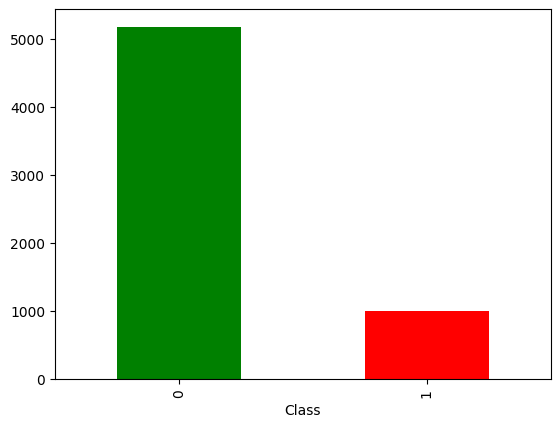

In [33]:
churn_df[Y_COLUMN].value_counts().plot.bar(color=['green', 'red'])

`RandomForestClassifier` has many hyperparameters that need to be tuned, we have pre-tuned the main parameters for you. You may also use the provided `grid_search_rf()` method to play with hyperparameter tuning yourself.


In [34]:
best_params_no_weight = {
    'bootstrap': True,
    'class_weight': None,
    'max_depth': 10,
    'min_samples_split': 5,
    'n_estimators': 50
}

In [38]:
X_train, X_test, y_train, y_test = split_data(churn_df, Y_COLUMN)

In [39]:
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_no_weight)

In [56]:
original = print_classification_metrics(y_test, preds)

Accuracy is: 0.86
Precision is: 0.68
Recall is: 0.28
Fscore is: 0.29
AUC is: 0.63


As you may expect, we have a very high prediction `accuracy` but even using a random forest classifier, our `recall` is very low with only 0.28. 
Next, let's try the class reweighting method to see if we can improve the performance.


### Add class re-weighting


In [41]:
class_weight = {0: 0.2, 1: 0.8}

In [42]:
best_params_weight = {
    'bootstrap': True,
    'class_weight': class_weight,
    'max_depth': 10,
    'min_samples_split': 5,
    'n_estimators': 50
}

In [44]:
preds_cw, weight_model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)

In [57]:
class_weights = print_classification_metrics(y_test, preds_cw, 'Class Weights')

Accuracy is: 0.81
Precision is: 0.45
Recall is: 0.62
Fscore is: 0.61
AUC is: 0.63


### Resampling: SMOTE and Undersampling


In [48]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

Then we can retrain a random forest classifier using SMOTE resampled input `X_smo` and output `y_smo` and evaluate its performance,


In [58]:
preds_smo, smo_model = build_rf(X_smo, y_smo, X_test, best_params=best_params_no_weight)
smote = print_classification_metrics(y_test, preds_smo, 'SMOTE')

Accuracy is: 0.84
Precision is: 0.50
Recall is: 0.53
Fscore is: 0.52
AUC is: 0.63


and we can retrain a random forest classifier using the undersampled input `X_under` and output `y_under` and evaluate its performance.


In [59]:
preds_under, under_model = build_rf(X_under, y_under, X_test, best_params=best_params_no_weight)
under = print_classification_metrics(y_test, preds_under, 'Under Sampling')

Accuracy is: 0.73
Precision is: 0.36
Recall is: 0.79
Fscore is: 0.75
AUC is: 0.63


In [60]:
results = [original, class_weights, smote, under]

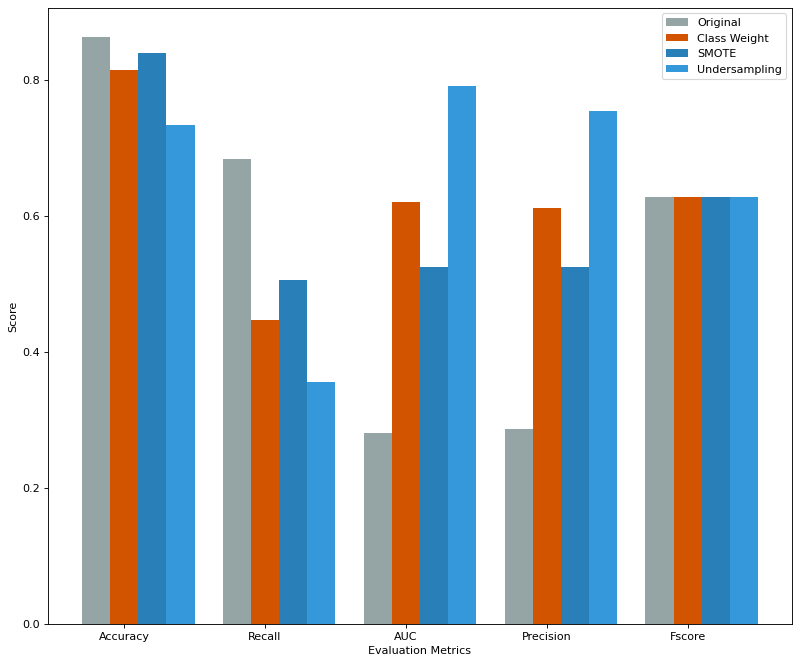

In [65]:
visualize_eval_metrics(results)

By analyzing the bar chart above, we can see that undersampling seems to be the best method to help alleviate the imbalanced challenge in the customer churn dataset. Although all class weights, SMOTE, and undersampling decreased the precision (increased false positives) but sometimes it is not a bad idea to assume some of your customers are about to leave (even if they are not) as motivation to improve your services.


- All models have high accuracy
- Recall is improved with class weights and resampling methods, and undersampling produces the highest recall
- AUC is also improved with class weights and resampling methods, and undersampling produces the highest AUC again
- Precisions are decreased with class weights and resampling methods as they all introduced many false positives (which are expected as we are trying to increase the impact of the positive class)
- Fscore is improved with class weights and resampling method, and undersampling has the highest Fscore


## Scenario: Tumor Type Estimation


Finally, let's see an interesting imbalanced dataset that has very high Precision, Recall, and F-score initially without using class reweighting and resampling.


This dataset contains tumor samples and we need to estimate/predict if a tumor sample is cancerous or not.

First, like other scenarios, let's load and split the dataset


In [67]:
tumor_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_cancer.csv", index_col=False)

In [68]:
tumor_df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,4,3,1,1,2,1,4,8,1,0
2,8,5,5,5,2,10,4,3,1,1
3,5,7,10,6,5,10,7,5,1,1
4,7,1,2,3,2,1,2,1,1,0


In [69]:
Y_COLUMN = 'Class'

In [70]:
X_train, X_test, y_train, y_test = split_data(tumor_df, Y_COLUMN)

<Axes: xlabel='Class'>

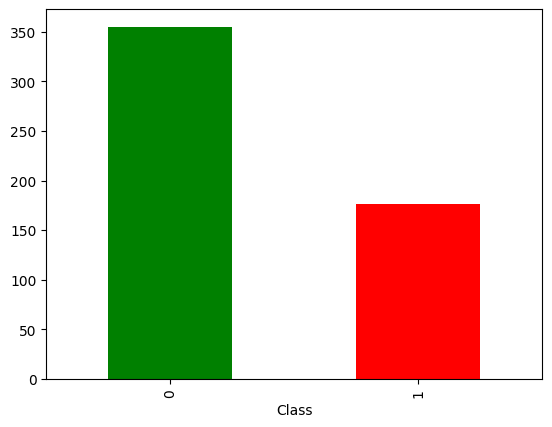

In [71]:
y_train.value_counts().plot.bar(color=['green', 'red'])

In [72]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

In [73]:
best_params_weight = {
    'bootstrap': True,
    'class_weight': {0: 0.2, 1: 0.8},
    'max_depth': 10,
    'min_samples_split': 5,
    'n_estimators': 50
}

In [74]:
results = []

In [77]:
preds, model = build_rf(X_train, y_train, X_test)
results.append(print_classification_metrics(y_test, preds))
# class weight
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
results.append(print_classification_metrics(y_test, preds))
# Resampling
preds, model = build_rf(X_smo, y_smo, X_test)
results.append(print_classification_metrics(y_test, preds))
preds, model = build_rf(X_under, y_under, X_test)
results.append(print_classification_metrics(y_test, preds))

Accuracy is: 0.98
Precision is: 0.96
Recall is: 1.00
Fscore is: 1.00
AUC is: 0.99


KeyError: 'bootstrap'